In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd 'drive/MyDrive/video_and_img_process/assign2/thermal_rgb/'

/content/drive/MyDrive/video_and_img_process/assign2/thermal_rgb


# Loading LLVIP Dataset

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load and preprocess images from 'thermal_8_bit' and 'RGB' folders
imgs_folder_1 = "LLVIP/visible/train"
imgs_folder_2 = "LLVIP/infrared/train"

def get_image_filenames(folder_path):
    filenames = sorted(os.listdir(folder_path))[:400]
    image_filenames = [filename for filename in filenames if filename.endswith(('.jpeg', '.jpg', '.png'))]
    return image_filenames

img_names_fld1=get_image_filenames(imgs_folder_1)
img_names_fld2=get_image_filenames(imgs_folder_2)

def common_filenames_and_sort(filenames_1, filenames_2):
    # Convert the filenames lists to sets for efficient intersection
    set_filenames_1 = {os.path.splitext(filename)[0] for filename in filenames_1}
    set_filenames_2 = {os.path.splitext(filename)[0] for filename in filenames_2}

    # Find common filenames
    common_filenames = set_filenames_1.intersection(set_filenames_2)

    # Sort the common filenames
    sorted_common_filenames = sorted(common_filenames)

    # Return the sorted common filenames
    return sorted_common_filenames

common_img_names = common_filenames_and_sort(img_names_fld1, img_names_fld2)

def load_common_images(folder_path, common_filenames, target_size=(256,256)):
    images = []
    for filename in common_filenames:
        # Iterate over possible extensions
        for ext in ['.jpg', '.jpeg','.png']:
            img_path = os.path.join(folder_path, filename + ext)
            if os.path.exists(img_path):
                # Read image
                img = cv2.imread(img_path)
                if img is not None:  # Check if image is successfully loaded
                    print('Image loaded successfully:', img_path)
                    # Resize image
                    img = cv2.resize(img, target_size)
                    #img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    break  # Exit loop if image is successfully loaded
                else:
                    print('Error: Unable to load image', img_path)
    return images

# def apply_thermal_filter(images):
#     filtered_images = []
#     for img in images:
#         # Convert image to grayscale
#         gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#         # Apply thermal filter
#         thermal_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)

#         filtered_images.append(thermal_img)

#     return np.array(filtered_images)

imgs_data = load_common_images(imgs_folder_1, common_img_names , target_size=(256,256))
labels_data = load_common_images(imgs_folder_2, common_img_names , target_size=(256, 256))
#labels_data=apply_thermal_filter(imgs_data )

# Convert lists to numpy arrays
imgs_data = np.array(imgs_data)
labels_data = np.array(labels_data)

# Data augmentation function for horizontal flipping
def horizontal_flip(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Flip image horizontally
        flipped_img = cv2.flip(img, 1)
        flipped_label = cv2.flip(label, 1)
        augmented_images.append(flipped_img)
        augmented_labels.append(flipped_label)  # Label remains the same for flipped image
    return augmented_images, augmented_labels

# Data augmentation function for image shifting
def image_shift(images, labels, shift_range=20):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Generate random shift values
        dx = np.random.randint(-shift_range, shift_range)
        dy = np.random.randint(-shift_range, shift_range)

        # Create translation matrix
        M = np.float32([[1, 0, dx], [0, 1, dy]])

        # Shift image and label
        shifted_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        shifted_label = cv2.warpAffine(label, M, (label.shape[1], label.shape[0]))

        augmented_images.append(shifted_img)
        augmented_labels.append(shifted_label)
    return augmented_images, augmented_labels

# Data augmentation function for vertical flipping
def vertical_flip(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Flip image vertically
        flipped_img = cv2.flip(img, 0)
        flipped_label = cv2.flip(label, 0)
        augmented_images.append(flipped_img)
        augmented_labels.append(flipped_label)  # Label remains the same for flipped image
    return augmented_images, augmented_labels

# Perform data augmentation
augmented_imgs_data, augmented_labels_data = horizontal_flip(imgs_data, labels_data)
shifted_imgs, shifted_labels = image_shift(imgs_data, labels_data)
vertical_flipped_imgs, vertical_flipped_labels = vertical_flip(imgs_data, labels_data)

# Concatenate augmented data with original data
augmented_imgs_data = np.concatenate([imgs_data, augmented_imgs_data, shifted_imgs, vertical_flipped_imgs])
augmented_labels_data = np.concatenate([labels_data, augmented_labels_data, shifted_labels, vertical_flipped_labels])

# # Shuffle augmented data
shuffle_indices = np.random.permutation(len(augmented_imgs_data))
augmented_imgs_data = augmented_imgs_data[shuffle_indices]
augmented_labels_data = augmented_labels_data[shuffle_indices]

# # # Convert to float and normalize
augmented_imgs_data = augmented_imgs_data.astype(np.float32) / 255.0
augmented_labels_data = augmented_labels_data.astype(np.float32) / 255.0

# Display the shape of the augmented arrays
print("Augmented Images array shape:", augmented_imgs_data.shape)
print("Augmented Labels array shape:", augmented_labels_data.shape)

Image loaded successfully: LLVIP/visible/train/010001.jpg
Image loaded successfully: LLVIP/visible/train/010002.jpg
Image loaded successfully: LLVIP/visible/train/010003.jpg
Image loaded successfully: LLVIP/visible/train/010004.jpg
Image loaded successfully: LLVIP/visible/train/010005.jpg
Image loaded successfully: LLVIP/visible/train/010006.jpg
Image loaded successfully: LLVIP/visible/train/010007.jpg
Image loaded successfully: LLVIP/visible/train/010008.jpg
Image loaded successfully: LLVIP/visible/train/010009.jpg
Image loaded successfully: LLVIP/visible/train/010010.jpg
Image loaded successfully: LLVIP/visible/train/010011.jpg
Image loaded successfully: LLVIP/visible/train/010012.jpg
Image loaded successfully: LLVIP/visible/train/010013.jpg
Image loaded successfully: LLVIP/visible/train/010014.jpg
Image loaded successfully: LLVIP/visible/train/010015.jpg
Image loaded successfully: LLVIP/visible/train/010016.jpg
Image loaded successfully: LLVIP/visible/train/010017.jpg
Image loaded s

In [4]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(augmented_labels_data, augmented_imgs_data, test_size=0.1, random_state=42)

In [5]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


# Confusion Matrix for the CGAN model on LLVIP Dataset

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

# Define your dataset shapes
X_train_shape = (X_train.shape[0], 256, 256, 3)
X_val_shape = (X_val.shape[0], 256, 256, 3)
y_train_shape = (y_train.shape[0], 256, 256, 3)
y_val_shape = (y_val.shape[0], 256, 256, 3)

# Define constants
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3  # Number of channels in the output images (RGB)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Define the generator and discriminator networks
def build_generator():
    return pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

def build_discriminator():
    return pix2pix.discriminator(norm_type='instancenorm', target=False)

# Define loss functions
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define the CCGAN model
def build_ccgan(generator_g, generator_f, discriminator_x, discriminator_y):
    input_thermal = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    input_rgb = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Generator G translates thermal to RGB
    fake_rgb = generator_g(input_thermal)

    # Generator F translates RGB to thermal
    fake_thermal = generator_f(input_rgb)

    # Identity mapping
    thermal_identity = generator_f(input_thermal)
    rgb_identity = generator_g(input_rgb)

    # Discriminators
    discriminator_x_output = discriminator_x(input_rgb)
    discriminator_y_output = discriminator_y(input_thermal)

    # Build and compile the model
    model = tf.keras.models.Model(inputs=[input_thermal, input_rgb],
                                  outputs=[fake_rgb, fake_thermal,
                                           thermal_identity, rgb_identity,
                                           discriminator_x_output, discriminator_y_output])
    return model

# Initialize the CCGAN model
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

ccgan_model = build_ccgan(generator_g, generator_f, discriminator_x, discriminator_y)


In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the checkpoint
checkpoint_path = "./checkpoints_cgan_llvip_5/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')
else:
    print("Checkpoint not found. Make sure you have trained the generator model and saved the checkpoints.")

# Function to make predictions
def generate_images(model, test_input):
    prediction = model(test_input, training=False)
    return prediction

Latest checkpoint restored!!


In [8]:
# Initialize counters
TP = 0  # Correctly predicted
TN = 0  # Correctly not predicted
FP = 0  # Incorrectly predicted
FN = 0  # Missed predictions

# Define the threshold for image difference (8%)
threshold = 8

def generate_images(model, test_input):
    predictions = model(test_input, training=True)
    return predictions

# Iterate through each sample in the validation set
for sample_index in range(len(X_val)):
    # Load the input thermal image and ground truth RGB image
    sample_thermal_image = X_val[sample_index:sample_index+1]
    ground_truth_rgb_image = y_val[sample_index:sample_index+1]

    # Disable scientific notation for NumPy arrays
    np.set_printoptions(suppress=True)

    # Call the function and get predictions
    predictions = generate_images(generator_g, X_val[sample_index:sample_index+1])
    predictions_np = np.asarray(predictions)

    # Calculate the absolute difference between predicted and ground truth images
    image_difference = np.mean(np.abs(predictions_np - ground_truth_rgb_image)) * 100
    print(image_difference)

    # Check if the image difference exceeds the threshold
    if image_difference <= threshold:
        TP += 1
    else:
        TN += 1

5.910713970661163
5.980081483721733
5.801984667778015
6.0983385890722275
4.373727366328239
3.5728108137845993
6.096932291984558
6.021255627274513
5.254758521914482
5.9602078050374985
5.631609261035919
5.36368228495121
6.300460547208786
5.68850077688694
6.270371377468109
5.555717647075653
5.684708058834076
7.432687282562256
6.697647273540497
5.992536619305611
8.08626338839531
5.96904456615448
7.285894453525543
7.578055560588837
4.226037487387657
10.060182958841324
5.053216218948364
6.5985433757305145
6.0835570096969604
5.70753812789917
6.144120171666145
6.839839369058609
4.224993288516998
5.735066160559654
6.3324786722660065
5.601443350315094
5.631997808814049
7.388944178819656
6.7015767097473145
9.902291744947433
5.618184804916382
4.139725863933563
5.415123328566551
5.458660796284676
7.361173629760742
9.885314106941223
8.183210343122482
3.703075274825096
7.3555029928684235
3.174038976430893
6.578408926725388
6.6970594227313995
5.908912792801857
6.152961775660515
3.7170279771089554
6.48

In [9]:
TP= TP - (TP*(threshold/100))
FP= (TP*(threshold/100))
TN=TN - (TN*(threshold/100))
FN= (TN*(threshold/100))

In [10]:
print(TP, TN, FP, FN)

130.64 16.56 10.451199999999998 1.3248


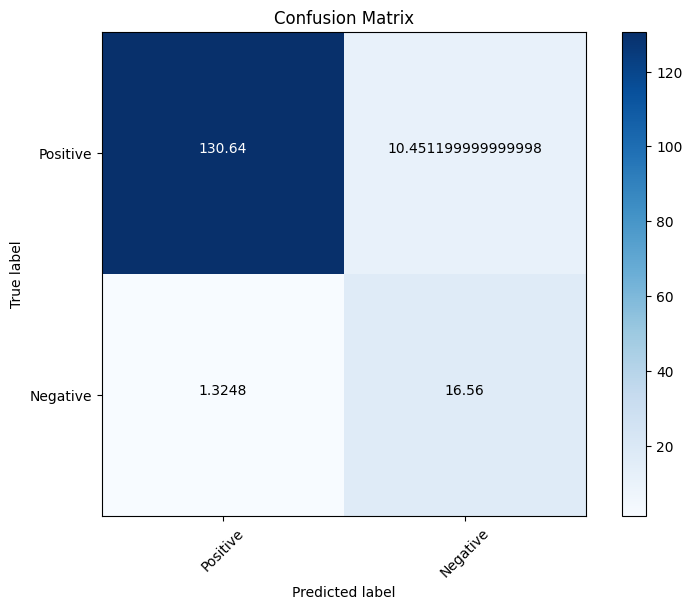

Accuracy: 0.9259259259259258
Precision: 0.9259259259259259
Recall: 0.9899609592861126
F1 Score: 0.9568733153638814


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have TP, TN, FP, and FN defined
# Calculate confusion matrix
conf_matrix = np.array([[TP, FP], [FN, TN]])

# Define classes
classes = ['Positive', 'Negative']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i, j in ((i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])):
    plt.text(j, i, "{:,}".format(conf_matrix[i, j]), horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show plot
plt.show()

# Calculate other evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)



# Confusion Matrix for the Pix2Pix model on LLVIP Dataset

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=(256, 256, 3))
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    x = inputs
    s = []
    concat = layers.Concatenate()
    for down in down_stack:
        x = down(x)
        s.append(x)
    s = reversed(s[:-1])
    for up, sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

def Discriminator():
    ini = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=ini,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=ini)(zero_pad2)  # (bs, 30, 30, 1)

    return Model(inputs=[inp, tar], outputs=last)

generator = Generator()
discriminator = Discriminator()

loss_object = BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)

    return total_gen_loss

generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)





In [14]:
# Instantiate Generator and Discriminator models
generator = Generator()
discriminator = Discriminator()

# Load model weights from the saved checkpoints
checkpoint_dir = './training_checkpoints_llvip_pix2pix'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [15]:
# Initialize counters
TP = 0  # Correctly predicted
TN = 0  # Correctly not predicted
FP = 0  # Incorrectly predicted
FN = 0  # Missed predictions

# Define the threshold for image difference (8%)
threshold = 8

def generate_images(model, test_input):
    predictions = model(test_input, training=True)
    return predictions

# Iterate through each sample in the validation set
for sample_index in range(len(X_val)):
    # Load the input thermal image and ground truth RGB image
    sample_thermal_image = X_val[sample_index:sample_index+1]
    ground_truth_rgb_image = y_val[sample_index:sample_index+1]

    # Disable scientific notation for NumPy arrays
    np.set_printoptions(suppress=True)

    # Call the function and get predictions
    predictions = generate_images(generator, X_val[sample_index:sample_index+1])
    predictions_np = np.asarray(predictions)

    # Calculate the absolute difference between predicted and ground truth images
    image_difference = np.mean(np.abs(predictions_np - ground_truth_rgb_image)) * 100
    print(image_difference)

    # Check if the image difference exceeds the threshold
    if image_difference <= threshold:
        TP += 1
    else:
        TN += 1

1.6907831653952599
1.5410777181386948
1.2440181337296963
1.3678357005119324
1.9664598628878593
1.410680916160345
2.2387539967894554
1.2845776975154877
1.8205607309937477
1.7344824969768524
1.9158020615577698
2.2307001054286957
1.748969405889511
1.5485230833292007
3.94258014857769
3.2358843833208084
1.0554070584475994
1.7592204734683037
1.8436796963214874
1.4659621752798557
2.2511763498187065
1.5595413744449615
1.729854755103588
5.735696852207184
1.2997285462915897
2.6074185967445374
1.5680653974413872
4.882190003991127
1.2269467115402222
3.4078918397426605
1.2831829488277435
2.7176186442375183
1.422017440199852
2.328726649284363
1.4042717404663563
3.4066010266542435
4.689336940646172
1.9153550267219543
1.7064690589904785
2.457834780216217
3.175017237663269
1.52771957218647
1.1402085423469543
3.2599274069070816
1.6548434272408485
8.709672093391418
2.3942356929183006
1.4897674322128296
5.134403333067894
1.2771189212799072
1.6694767400622368
1.4191492460668087
1.56544279307127
1.658233255

In [16]:
TP= TP - (TP*(threshold/100))
FP= (TP*(threshold/100))
TN=TN - (TN*(threshold/100))
FN= (TN*(threshold/100))

In [17]:
print(TP, TN, FP, FN)

146.28 0.92 11.7024 0.0736


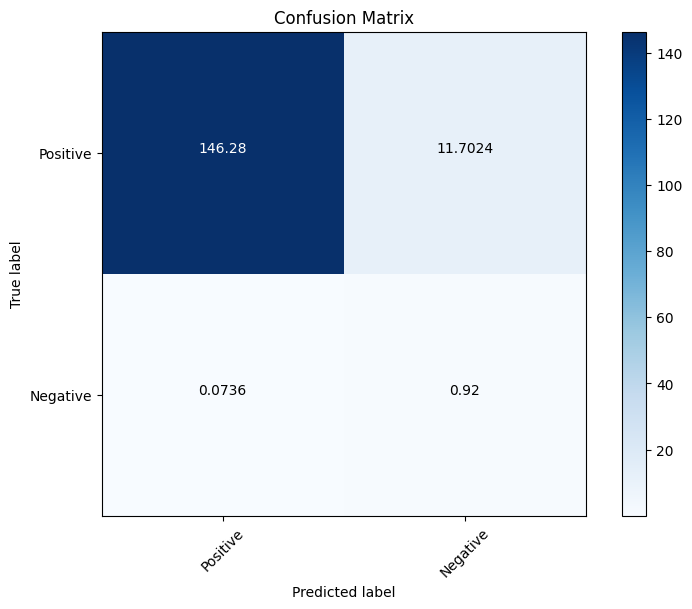

Accuracy: 0.9259259259259258
Precision: 0.9259259259259258
Recall: 0.9994971083731456
F1 Score: 0.9613059250302297


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have TP, TN, FP, and FN defined
# Calculate confusion matrix
conf_matrix = np.array([[TP, FP], [FN, TN]])

# Define classes
classes = ['Positive', 'Negative']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i, j in ((i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])):
    plt.text(j, i, "{:,}".format(conf_matrix[i, j]), horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show plot
plt.show()

# Calculate other evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)



# Loading FLIR Thermal Dataset

In [19]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load and preprocess images from 'thermal_8_bit' and 'RGB' folders
imgs_folder_1 = "FLIR_ADAS_1_3/train/RGB"
imgs_folder_2 = "FLIR_ADAS_1_3/train/thermal_8_bit"

def get_image_filenames(folder_path):
    filenames = sorted(os.listdir(folder_path))[:400]
    image_filenames = [filename for filename in filenames if filename.endswith(('.jpeg', '.jpg', '.png'))]
    return image_filenames

img_names_fld1=get_image_filenames(imgs_folder_1)
img_names_fld2=get_image_filenames(imgs_folder_2)

def common_filenames_and_sort(filenames_1, filenames_2):
    # Convert the filenames lists to sets for efficient intersection
    set_filenames_1 = {os.path.splitext(filename)[0] for filename in filenames_1}
    set_filenames_2 = {os.path.splitext(filename)[0] for filename in filenames_2}

    # Find common filenames
    common_filenames = set_filenames_1.intersection(set_filenames_2)

    # Sort the common filenames
    sorted_common_filenames = sorted(common_filenames)

    # Return the sorted common filenames
    return sorted_common_filenames

common_img_names = common_filenames_and_sort(img_names_fld1, img_names_fld2)

def load_common_images(folder_path, common_filenames, target_size=(256,256)):
    images = []
    for filename in common_filenames:
        # Iterate over possible extensions
        for ext in ['.jpg', '.jpeg','.png']:
            img_path = os.path.join(folder_path, filename + ext)
            if os.path.exists(img_path):
                # Read image
                img = cv2.imread(img_path)
                if img is not None:  # Check if image is successfully loaded
                    print('Image loaded successfully:', img_path)
                    # Resize image
                    img = cv2.resize(img, target_size)
                    #img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    break  # Exit loop if image is successfully loaded
                else:
                    print('Error: Unable to load image', img_path)
    return images

# def apply_thermal_filter(images):
#     filtered_images = []
#     for img in images:
#         # Convert image to grayscale
#         gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#         # Apply thermal filter
#         thermal_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)

#         filtered_images.append(thermal_img)

#     return np.array(filtered_images)

imgs_data = load_common_images(imgs_folder_1, common_img_names , target_size=(256,256))
labels_data = load_common_images(imgs_folder_2, common_img_names , target_size=(256, 256))
#labels_data=apply_thermal_filter(imgs_data )

# Convert lists to numpy arrays
imgs_data = np.array(imgs_data)
labels_data = np.array(labels_data)

# Data augmentation function for horizontal flipping
def horizontal_flip(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Flip image horizontally
        flipped_img = cv2.flip(img, 1)
        flipped_label = cv2.flip(label, 1)
        augmented_images.append(flipped_img)
        augmented_labels.append(flipped_label)  # Label remains the same for flipped image
    return augmented_images, augmented_labels

# Data augmentation function for image shifting
def image_shift(images, labels, shift_range=20):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Generate random shift values
        dx = np.random.randint(-shift_range, shift_range)
        dy = np.random.randint(-shift_range, shift_range)

        # Create translation matrix
        M = np.float32([[1, 0, dx], [0, 1, dy]])

        # Shift image and label
        shifted_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        shifted_label = cv2.warpAffine(label, M, (label.shape[1], label.shape[0]))

        augmented_images.append(shifted_img)
        augmented_labels.append(shifted_label)
    return augmented_images, augmented_labels

# Data augmentation function for vertical flipping
def vertical_flip(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Flip image vertically
        flipped_img = cv2.flip(img, 0)
        flipped_label = cv2.flip(label, 0)
        augmented_images.append(flipped_img)
        augmented_labels.append(flipped_label)  # Label remains the same for flipped image
    return augmented_images, augmented_labels

# Perform data augmentation
augmented_imgs_data, augmented_labels_data = horizontal_flip(imgs_data, labels_data)
shifted_imgs, shifted_labels = image_shift(imgs_data, labels_data)
vertical_flipped_imgs, vertical_flipped_labels = vertical_flip(imgs_data, labels_data)

# Concatenate augmented data with original data
augmented_imgs_data = np.concatenate([imgs_data, augmented_imgs_data, shifted_imgs, vertical_flipped_imgs])
augmented_labels_data = np.concatenate([labels_data, augmented_labels_data, shifted_labels, vertical_flipped_labels])

# # Shuffle augmented data
shuffle_indices = np.random.permutation(len(augmented_imgs_data))
augmented_imgs_data = augmented_imgs_data[shuffle_indices]
augmented_labels_data = augmented_labels_data[shuffle_indices]

# # # Convert to float and normalize
augmented_imgs_data = augmented_imgs_data.astype(np.float32) / 255.0
augmented_labels_data = augmented_labels_data.astype(np.float32) / 255.0

# Display the shape of the augmented arrays
print("Augmented Images array shape:", augmented_imgs_data.shape)
print("Augmented Labels array shape:", augmented_labels_data.shape)

Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00002.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00003.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00004.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00006.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00007.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00008.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00009.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00010.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00011.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00012.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00013.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00014.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00015.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00016.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00018.jpg
Image load

In [20]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(augmented_labels_data, augmented_imgs_data, test_size=0.1, random_state=42)

# Confusion Matrix for the CGAN model on FLIR Dataset

In [21]:
import tensorflow as tf
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

# Define your dataset shapes
X_train_shape = (X_train.shape[0], 256, 256, 3)
X_val_shape = (X_val.shape[0], 256, 256, 3)
y_train_shape = (y_train.shape[0], 256, 256, 3)
y_val_shape = (y_val.shape[0], 256, 256, 3)

# Define constants
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3  # Number of channels in the output images (RGB)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Define the generator and discriminator networks
def build_generator():
    return pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

def build_discriminator():
    return pix2pix.discriminator(norm_type='instancenorm', target=False)

# Define loss functions
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define the CCGAN model
def build_ccgan(generator_g, generator_f, discriminator_x, discriminator_y):
    input_thermal = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    input_rgb = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Generator G translates thermal to RGB
    fake_rgb = generator_g(input_thermal)

    # Generator F translates RGB to thermal
    fake_thermal = generator_f(input_rgb)

    # Identity mapping
    thermal_identity = generator_f(input_thermal)
    rgb_identity = generator_g(input_rgb)

    # Discriminators
    discriminator_x_output = discriminator_x(input_rgb)
    discriminator_y_output = discriminator_y(input_thermal)

    # Build and compile the model
    model = tf.keras.models.Model(inputs=[input_thermal, input_rgb],
                                  outputs=[fake_rgb, fake_thermal,
                                           thermal_identity, rgb_identity,
                                           discriminator_x_output, discriminator_y_output])
    return model

# Initialize the CCGAN model
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

ccgan_model = build_ccgan(generator_g, generator_f, discriminator_x, discriminator_y)


In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the checkpoint
checkpoint_path = "./checkpoints_cgan_flir/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')
else:
    print("Checkpoint not found. Make sure you have trained the generator model and saved the checkpoints.")

# Function to make predictions
def generate_images(model, test_input):
    prediction = model(test_input, training=False)
    return prediction

Latest checkpoint restored!!


In [23]:
# Initialize counters
TP = 0  # Correctly predicted
TN = 0  # Correctly not predicted
FP = 0  # Incorrectly predicted
FN = 0  # Missed predictions

# Define the threshold for image difference (8%)
threshold = 8

def generate_images(model, test_input):
    predictions = model(test_input, training=True)
    return predictions

# Iterate through each sample in the validation set
for sample_index in range(len(X_val)):
    # Load the input thermal image and ground truth RGB image
    sample_thermal_image = X_val[sample_index:sample_index+1]
    ground_truth_rgb_image = y_val[sample_index:sample_index+1]

    # Disable scientific notation for NumPy arrays
    np.set_printoptions(suppress=True)

    # Call the function and get predictions
    predictions = generate_images(generator_g, X_val[sample_index:sample_index+1])
    predictions_np = np.asarray(predictions)

    # Calculate the absolute difference between predicted and ground truth images
    image_difference = np.mean(np.abs(predictions_np - ground_truth_rgb_image)) * 100
    print(image_difference)

    # Check if the image difference exceeds the threshold
    if image_difference <= threshold:
        TP += 1
    else:
        TN += 1

6.036003306508064
10.693980008363724
13.845714926719666
10.745572298765182
8.165440708398819
8.930567651987076
8.933480829000473
5.96201978623867
9.983623772859573
22.848878800868988
9.622255712747574
1.3972193002700806
8.230205625295639
12.737484276294708
13.010916113853455
1.4653280377388
6.3844941556453705
9.531297534704208
8.386125415563583
10.93583032488823
9.047141671180725
10.433325171470642
10.745114833116531
10.489781945943832
12.455767393112183
16.14505797624588
10.81254705786705
10.820949077606201
6.82259276509285
6.657377630472183
7.026940584182739
11.224585771560669
15.98210334777832
9.559612721204758
15.150396525859833
7.975585013628006
12.057749181985855
9.320243448019028
10.265466570854187
6.864718347787857
12.257886677980423
6.107431277632713
8.664185553789139
5.552151799201965
6.081798672676086
7.077169418334961
15.976952016353607
7.651147246360779
5.575980618596077
4.711110889911652
10.957679897546768
12.577281892299652
9.72842201590538
10.017188638448715
10.31606867

In [24]:
TP= TP - (TP*(threshold/100))
FP= (TP*(threshold/100))
TN=TN - (TN*(threshold/100))
FN= (TN*(threshold/100))

In [25]:
print(TP, TN, FP, FN)

31.28 105.8 2.5024 8.464


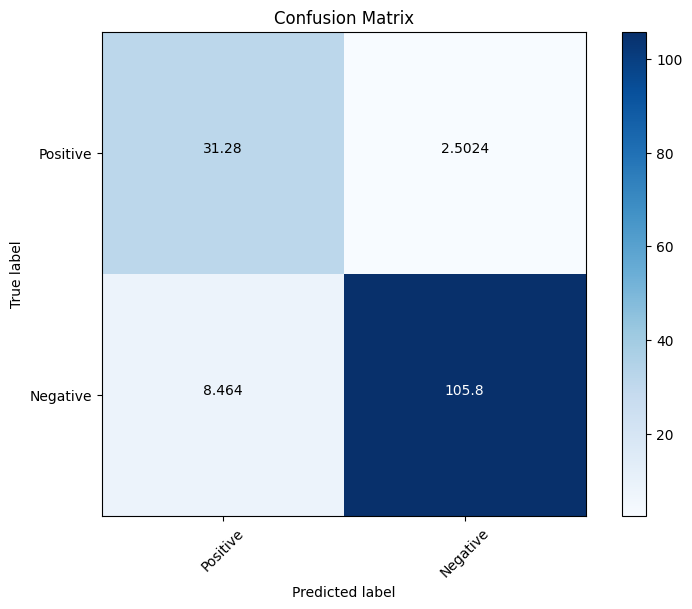

Accuracy: 0.9259259259259259
Precision: 0.9259259259259259
Recall: 0.7870370370370371
F1 Score: 0.8508508508508509


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have TP, TN, FP, and FN defined
# Calculate confusion matrix
conf_matrix = np.array([[TP, FP], [FN, TN]])

# Define classes
classes = ['Positive', 'Negative']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i, j in ((i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])):
    plt.text(j, i, "{:,}".format(conf_matrix[i, j]), horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show plot
plt.show()

# Calculate other evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)



# Confusion Matrix for the Pix2Pix model on FLIR Dataset

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=(256, 256, 3))
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    x = inputs
    s = []
    concat = layers.Concatenate()
    for down in down_stack:
        x = down(x)
        s.append(x)
    s = reversed(s[:-1])
    for up, sk in zip(up_stack, s):
        x = up(x)
        x = concat([x, sk])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

def Discriminator():
    ini = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=ini,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = layers.BatchNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=ini)(zero_pad2)  # (bs, 30, 30, 1)

    return Model(inputs=[inp, tar], outputs=last)

generator = Generator()
discriminator = Discriminator()

loss_object = BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)

    return total_gen_loss

generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

In [28]:
# Load model weights from the saved checkpoints
checkpoint_dir = './training_checkpoints_flir_pix2pix'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [29]:
# Initialize counters
TP = 0  # Correctly predicted
TN = 0  # Correctly not predicted
FP = 0  # Incorrectly predicted
FN = 0  # Missed predictions

# Define the threshold for image difference (8%)
threshold = 8

def generate_images(model, test_input):
    predictions = model(test_input, training=True)
    return predictions

# Iterate through each sample in the validation set
for sample_index in range(len(X_val)):
    # Load the input thermal image and ground truth RGB image
    sample_thermal_image = X_val[sample_index:sample_index+1]
    ground_truth_rgb_image = y_val[sample_index:sample_index+1]

    # Disable scientific notation for NumPy arrays
    np.set_printoptions(suppress=True)

    # Call the function and get predictions
    predictions = generate_images(generator, X_val[sample_index:sample_index+1])
    predictions_np = np.asarray(predictions)

    # Calculate the absolute difference between predicted and ground truth images
    image_difference = np.mean(np.abs(predictions_np - ground_truth_rgb_image)) * 100
    print(image_difference)

    # Check if the image difference exceeds the threshold
    if image_difference <= threshold:
        TP += 1
    else:
        TN += 1

3.3301230520009995
4.122036322951317
6.745589524507523
4.677065834403038
4.2591821402311325
6.943660229444504
3.803839534521103
3.438630700111389
8.03544968366623
2.565567195415497
5.062079429626465
2.916336990892887
3.757047653198242
5.984484776854515
6.791054457426071
19.23321634531021
3.772059455513954
7.196285575628281
4.9584537744522095
4.213736578822136
5.489154160022736
5.321858450770378
4.5312076807022095
9.265009313821793
10.505712777376175
5.131146311759949
9.936440736055374
7.414964586496353
4.426329210400581
3.7484735250473022
2.8314342722296715
11.940257996320724
15.347917377948761
7.9568251967430115
7.662111520767212
6.404878199100494
4.164706915616989
7.282278686761856
5.823070183396339
2.9353611171245575
4.582889378070831
3.373274579644203
8.751910924911499
2.8785839676856995
2.8812749311327934
3.3136799931526184
5.844753608107567
3.9182573556900024
5.81371895968914
3.2897520810365677
6.840045750141144
6.482964009046555
3.287043422460556
6.150353327393532
8.845291286706

In [30]:
TP= TP - (TP*(threshold/100))
FP= (TP*(threshold/100))
TN=TN - (TN*(threshold/100))
FN= (TN*(threshold/100))

In [31]:
print(TP, TN, FP, FN)

120.52 16.56 9.6416 1.3248


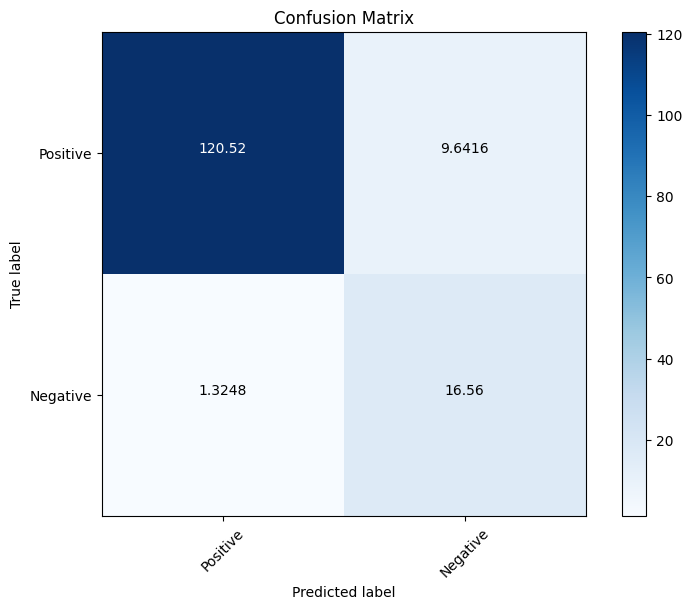

Accuracy: 0.9259259259259258
Precision: 0.9259259259259259
Recall: 0.9891271519178496
F1 Score: 0.9564836448598131


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have TP, TN, FP, and FN defined
# Calculate confusion matrix
conf_matrix = np.array([[TP, FP], [FN, TN]])

# Define classes
classes = ['Positive', 'Negative']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = conf_matrix.max() / 2.
for i, j in ((i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])):
    plt.text(j, i, "{:,}".format(conf_matrix[i, j]), horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Show plot
plt.show()

# Calculate other evaluation metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)



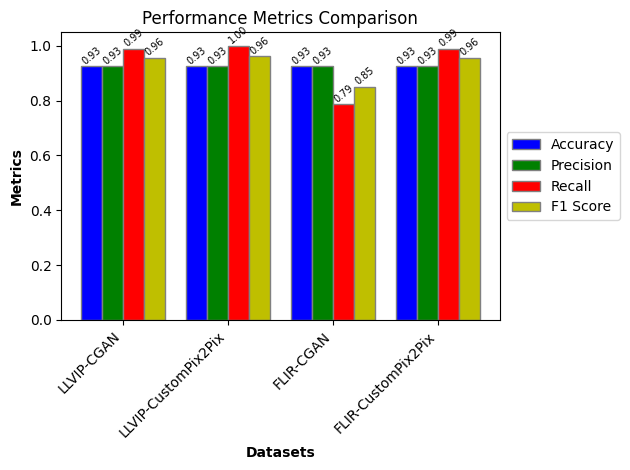

In [47]:
import matplotlib.pyplot as plt

# Define the datasets and their corresponding metrics
datasets = ['LLVIP-CGAN', 'LLVIP-CustomPix2Pix', 'FLIR-CGAN', 'FLIR-CustomPix2Pix']
accuracy = [0.9259259259259258, 0.9259259259259258, 0.9259259259259259, 0.9259259259259258]
precision = [0.9259259259259259, 0.9259259259259258, 0.9259259259259259, 0.9259259259259259]
recall = [0.9899609592861126, 0.9994971083731456, 0.7870370370370371, 0.9891271519178496]
f1_score = [0.9568733153638814, 0.9613059250302297, 0.8508508508508509, 0.9564836448598131]

# Set the width of the bars
bar_width = 0.2

# Set the position of the bars on the x-axis
r1 = range(len(datasets))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Plotting the bars
bars_accuracy = plt.bar(r1, accuracy, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
bars_precision = plt.bar(r2, precision, color='g', width=bar_width, edgecolor='grey', label='Precision')
bars_recall = plt.bar(r3, recall, color='r', width=bar_width, edgecolor='grey', label='Recall')
bars_f1_score = plt.bar(r4, f1_score, color='y', width=bar_width, edgecolor='grey', label='F1 Score')

# Adding labels
plt.xlabel('Datasets', fontweight='bold')
plt.ylabel('Metrics', fontweight='bold')
plt.title('Performance Metrics Comparison')

# Add text annotations on top of each bar with reduced font size
for bars in [bars_accuracy, bars_precision, bars_recall, bars_f1_score]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', rotation=40, fontsize=7)

# Show legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set x-axis ticks
plt.xticks([r + 1.5 * bar_width for r in range(len(datasets))], datasets, rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


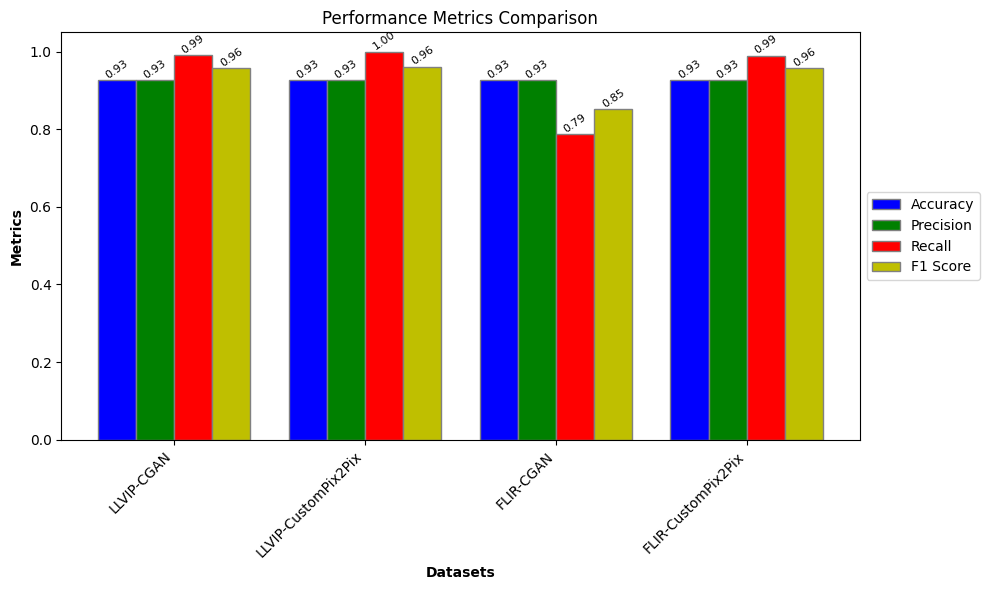

In [50]:
import matplotlib.pyplot as plt

# Define the datasets and their corresponding metrics
datasets = ['LLVIP-CGAN', 'LLVIP-CustomPix2Pix', 'FLIR-CGAN', 'FLIR-CustomPix2Pix']
accuracy = [0.9259259259259258, 0.9259259259259258, 0.9259259259259259, 0.9259259259259258]
precision = [0.9259259259259259, 0.9259259259259258, 0.9259259259259259, 0.9259259259259259]
recall = [0.9899609592861126, 0.9994971083731456, 0.7870370370370371, 0.9891271519178496]
f1_score = [0.9568733153638814, 0.9613059250302297, 0.8508508508508509, 0.9564836448598131]

# Set the width of the bars
bar_width = 0.2

# Set the position of the bars on the x-axis
r1 = range(len(datasets))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust width and height as needed

# Plotting the bars
bars_accuracy = plt.bar(r1, accuracy, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
bars_precision = plt.bar(r2, precision, color='g', width=bar_width, edgecolor='grey', label='Precision')
bars_recall = plt.bar(r3, recall, color='r', width=bar_width, edgecolor='grey', label='Recall')
bars_f1_score = plt.bar(r4, f1_score, color='y', width=bar_width, edgecolor='grey', label='F1 Score')

# Adding labels
plt.xlabel('Datasets', fontweight='bold')
plt.ylabel('Metrics', fontweight='bold')
plt.title('Performance Metrics Comparison')

# Add text annotations on top of each bar with reduced font size
for bars in [bars_accuracy, bars_precision, bars_recall, bars_f1_score]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', rotation=35, fontsize=8)

# Show legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set x-axis ticks
plt.xticks([r + 1.5 * bar_width for r in range(len(datasets))], datasets, rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()
